In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os

In [34]:
directory_path = "../experiment/"

# Get all CSV file names in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)


In [35]:
gaze_methods = ['NoControl', 'LookAhead', 'Owl', 'Rotating', 'Oxford']
planners = ['Jerk_Primitive', 'Primitive', 'MPC']
agent_numbers = [5, 10, 15]
pillar_numbers = [0, 5, 10]
agent_max_speeds = [20, 30, 40, 50]
drone_max_speeds = [20, 30, 40]

result_df = {
    'Method':[],
    'Planner':[],
    'Number of agents':[],
    'Number of pillars':[],
    'Agent speed':[],
    'Drone speed':[]
}
result_df = pd.DataFrame([], columns=['Method', 
                                      'Planner', 
                                      'Number of agents', 
                                      'Number of pillars', 
                                      'Agent speed', 
                                      'Drone speed',
                                      'Total samples',
                                      'Success',
                                      'Static collision',
                                      'Dynamic collision',
                                      'Area covered per step',
                                      'Agent tracked per step',
                                      'Agent tracking time'])
result_df
# df.T.plot(kind='bar', title='From Mon To Fri')
# plt.show()

,Method,Planner,Number of agents,Number of pillars,Agent speed,Drone speed,Total samples,Success,Static collision,Dynamic collision,Area covered per step,Agent tracked per step,Agent tracking time


In [36]:
result_df = pd.DataFrame([], columns=['Method', 
                                      'Planner', 
                                      'Number of agents', 
                                      'Number of pillars', 
                                      'Agent speed', 
                                      'Drone speed',
                                      'Total samples',
                                      'Success',
                                      'Static collision',
                                      'Dynamic collision',
                                      'Area covered per step',
                                      'Agent tracked per step',
                                      'Agent tracking time'])
for gaze_method in gaze_methods:
    for agent_number in agent_numbers:
        for pillar_number in pillar_numbers:
            for agent_speed in agent_max_speeds:
                for drone_speed in drone_max_speeds:
                    for planner in planners:
                        df_i = df[(df['Method'] == gaze_method) &
                                  (df['Planner'] == planner) &
                                  (df['Number of agents']==agent_number) & 
                                  (df['Number of pillars']==pillar_number) &
                                  (df['Agent speed']==agent_speed) &
                                  (df['Drone speed']==drone_speed) &
                                  (df['Steps'] >= 10)].copy(deep=True)
                        if df_i.shape[0] != 0:
                            # df_i.loc[df['Agent tracked']==0,'Agent tracked time'] = 0
                            df_i.loc[:,'Total track time'] = df_i.loc[:,'Agent tracked time']*df_i.loc[:,'Agent tracked']
                            # print(df_i)
                            result_df.loc[len(result_df)] = [
                                gaze_method,
                                planner,
                                agent_number,
                                pillar_number,
                                agent_speed,
                                drone_speed,
                                df_i.shape[0], #total samples
                                df_i['Success'].sum(),#total success
                                df_i['Static Collision'].sum(),
                                df_i['Dynamic Collision'].sum(),
                                df_i['Grid discovered'].sum() / df_i['Steps'].sum(),
                                100 * df_i['Agent tracked'].sum() / df_i['Steps'].sum(),
                                df_i['Total track time'].sum() / (df_i['Agent tracked']).sum()
                            ]
result_df['Success rate'] = result_df['Success'] / result_df['Total samples']
result_df['Velocity ratio'] = result_df['Agent speed'] / result_df['Drone speed']
result_df.to_csv('./post.csv')                            

/tmp/ipykernel_15623/3388254729.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_single = df[result_df[x_label] == x_value]


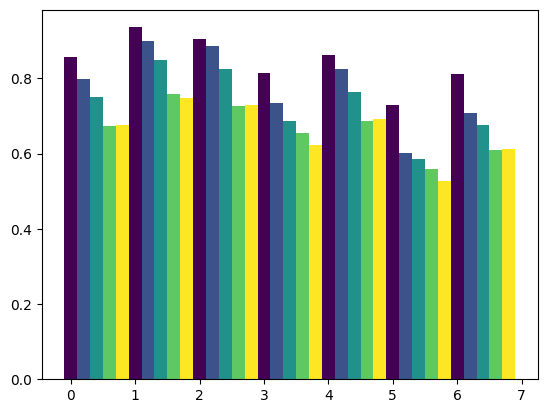

In [37]:
import matplotlib as mpl
fig, ax = plt.subplots()
width = 0.2
x_label = 'Velocity ratio'
legend = 'Method'

x_values = result_df[x_label].unique()
labels = result_df[legend].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

for i, label in enumerate(labels):
    
    df = result_df[result_df[legend] == label]
    y_values = []
    rects = []

    for x_value in x_values:
        df_single = df[result_df[x_label] == x_value]
        y_values.append(df_single['Success'].sum() / df_single['Total samples'].sum())
    
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, y_values, width, color=colors[i]))
    
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
labels = ['A', 'B', 'C', 'D', 'E']
values1 = [20, 35, 30, 25, 15]
values2 = [25, 30, 10, 20, 40]
values3 = [10, 25, 35, 15, 20]

# Set the positions and width of the bars
pos = np.arange(len(labels))
width = 0.2

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars for each value
cmap = mpl.cm.get_cmap("viridis", 3)
colors = cmap(np.linspace(0, 1, 3))
rects1 = ax.bar(pos, values1, width, color=colors[0])
rects2 = ax.bar(pos + width, values2, width, color=colors[1])
rects3 = ax.bar(pos + 2*width, values3, width, color=colors[2])

# Add a legend for each set of bars
ax.legend((rects1[0], rects2[0], rects3[0]), ('Legend 1', 'Legend 2', 'Legend 3'))

# Set the title and labels for the plot
ax.set_title('Bar Graph with Multiple Legends')
ax.set_xlabel('Labels')
ax.set_ylabel('Values')

# Set the tick labels for the x-axis
ax.set_xticks(pos + width)
ax.set_xticklabels(labels)

# Show the plot
plt.show()
